# Finite Differences
Solving golden model 1 using the following approximation

$\frac{u^{n+1/2}_{ij} - u^{n}_{ij}}{\tau}$ = $\Lambda_{i}u^{n+1/2}_{ij} + \Lambda_{j}u^{n}_{ij} - f_{ij}$

$\frac{u^{n+1}_{ij} - u^{n+1/2}_{ij}}{\tau}$ = $\Lambda_{j}(u^{n+1}_{ij} - u^{n}_{ij})$

In [39]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

## 1. Plot the actual solution

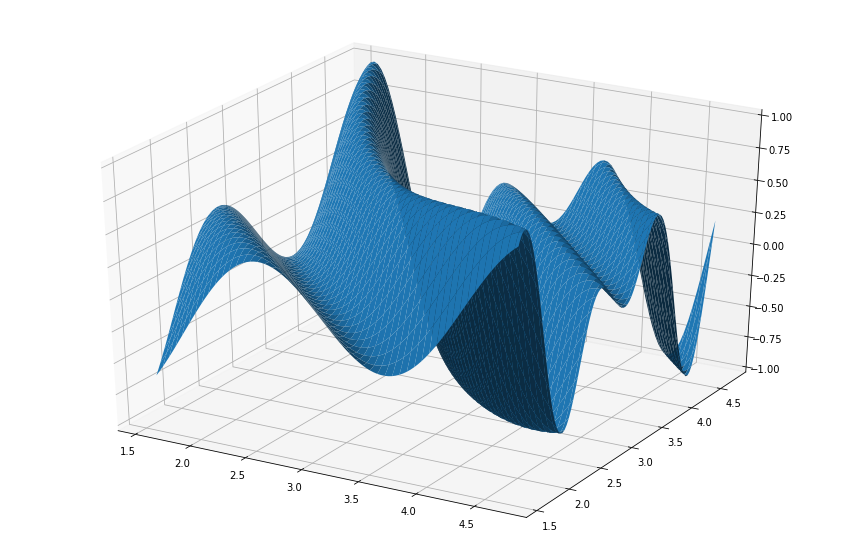

In [40]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

x_start = np.pi / 2.0
x_end = 1.5 * np.pi
N = 100
x_delta = (x_end - x_start) / (N-1)

y_start = np.pi / 2.0
y_end = 1.5 * np.pi
N = 100
y_delta = (y_end - y_start) / (N-1)

X = np.arange(x_start, x_end+0.1*x_delta, x_delta)
Y = np.arange(y_start, y_end+0.1*y_delta, y_delta)
X, Y = np.meshgrid(X, Y)
Z = np.cos(X + Y) * np.sin(X*Y)

surf = ax.plot_surface(X, Y, Z)
ax.set_zlim(-1, 1)

plt.show()

## 2. Time t=0, we have
Here we choose xy convention for how grid looks in numpy matrices. xy-convention means that

```python
x-grid = [[x0, x1, x2, x3], [x0, x1, x2, x3], ...]
y-grid = [[y0, y0, y0, y0], [y1, y1, y1, y1], [y2, y2, y2, y2]
```

In [57]:
# helper to fill in the f-values
#def give_me_func(x_delta, y_delta):
#    def func(i, j):
#        x = i*x_delta
#        y = j*y_delta
#        return -np.cos(x+y)*np.sin(x*y)*(2 + x*x + y*y)- 2*np.sin(x+y)*np.cos(x*y)*(x+y)
#    return func

def compute_f_values(Nx, Ny, x_delta, y_delta, x_start, y_start):
    i = np.arange(0, Nx, 1)
    j = np.arange(0, Ny, 1)
    i, j = np.meshgrid(i, j, indexing='xy')
    x = i*x_delta + x_start
    y = j*y_delta + y_start
    return -np.cos(x+y)*np.sin(x*y)*(2 + x*x + y*y)- 2*np.sin(x+y)*np.cos(x*y)*(x+y)

# x conditions
Nx = 50
x_start = np.pi * 0.5
x_end = np.pi * 1.5
x_delta = (x_end - x_start) / (Nx - 1)

# y conditions
Ny = 50
y_start = np.pi * 0.5
y_end = np.pi * 1.5
y_delta = (y_end - y_start) / (Ny - 1)

eps = 0.001
tau = 0.001

u_gold_func = lambda x,y: np.cos(x + y) * np.sin(x*y)
f_values = compute_f_values(Nx, Ny, x_delta, y_delta, x_start, y_start)

C = u_gold_func(np.pi*0.5, np.pi*.05)
u_values = np.zeros((Ny, Nx))
u_values.fill(C)
print(1.0 / (x_delta * x_delta), 1.0 / (y_delta * y_delta))

243.27216192525304 243.27216192525304


### 3. Define computations we need to perform
- computing matrix A
- computing vector b
- solver for $\textbf{A}u = b$
- matrix A below is built the following way:
 - remember the convention for the u matrix
 - number of rows/cols is the number of equations (Nx * Ny)
 - the mapping from the point of the network to the linear equation is: given (row, col) identifying idx = row*N + col
 - mapping backwards is: row = idx / N and col = idx % N

In [58]:
def compute_vector_b_step0(u_values, u_gold_func, f_values, tau, x_start, x_delta, Nx, y_start, y_delta, Ny, verbose):
    i = np.arange(0, Nx, 1)
    j = np.arange(0, Ny, 1)
    i_mesh, j_mesh = np.meshgrid(i, j, indexing="xy")
    x_mesh = i_mesh * x_delta + x_start
    y_mesh = j_mesh * y_delta + y_start
    
    # b values
    b = np.zeros((Ny, Nx))
    
    # boundary
    b[i_mesh==0] = u_gold_func(x_mesh[i_mesh==0], y_mesh[i_mesh==0])
    b[i_mesh==Nx-1] = u_gold_func(x_mesh[i_mesh==Nx-1], y_mesh[i_mesh==Nx-1])
    b[j_mesh==0] = u_gold_func(x_mesh[j_mesh==0], y_mesh[j_mesh==0])
    b[j_mesh==Ny-1] = u_gold_func(x_mesh[j_mesh==Ny-1], y_mesh[j_mesh==Ny-1])
    
    # internal network
    x_delta_2 = x_delta * x_delta
    y_delta_2 = y_delta * y_delta
    #lambda_x = (u_values[1:Ny-1, 2:Nx] - 2*u_values[1:Ny-1, 1:Nx-1] + u_values[1:Ny-1, 0:Nx-2]) / x_delta_2
    lambda_y = (u_values[2:Ny, 1:Nx-1] - 2*u_values[1:Ny-1, 1:Nx-1] + u_values[0:Ny-2, 1:Nx-1]) / y_delta_2
    update = tau * (lambda_y - f_values[1:Ny-1, 1:Nx-1])
    b[1:Ny-1, 1:Nx-1] = u_values[1:Ny-1, 1:Nx-1] + update
    return b

def compute_vector_b_step1(u_values_step0, u_values_step1, u_gold_func, f_values, tau, x_start, x_delta, Nx, y_start, y_delta, Ny, verbose):
    i = np.arange(0, Nx, 1)
    j = np.arange(0, Ny, 1)
    i_mesh, j_mesh = np.meshgrid(i, j, indexing="xy")
    x_mesh = i_mesh * x_delta + x_start
    y_mesh = j_mesh * y_delta + y_start
    
    # b values
    b = np.zeros((Ny, Nx))
    
    # boundary
    b[i_mesh==0] = u_gold_func(x_mesh[i_mesh==0], y_mesh[i_mesh==0])
    b[i_mesh==Nx-1] = u_gold_func(x_mesh[i_mesh==Nx-1], y_mesh[i_mesh==Nx-1])
    b[j_mesh==0] = u_gold_func(x_mesh[j_mesh==0], y_mesh[j_mesh==0])
    b[j_mesh==Ny-1] = u_gold_func(x_mesh[j_mesh==Ny-1], y_mesh[j_mesh==Ny-1])
    
    # internal network
    x_delta_2 = x_delta * x_delta
    y_delta_2 = y_delta * y_delta
    #lambda_x = (u_values[1:Ny-1, 2:Nx] - 2*u_values[1:Ny-1, 1:Nx-1] + u_values[1:Ny-1, 0:Nx-2]) / x_delta_2
    lambda_y = (u_values_step0[2:Ny, 1:Nx-1] - 2*u_values_step0[1:Ny-1, 1:Nx-1] + u_values_step0[0:Ny-2, 1:Nx-1]) / y_delta_2
    #update = tau * (lambda_y - f_values[1:Ny-1, 1:Nx-1])
    b[1:Ny-1, 1:Nx-1] = u_values_step1[1:Ny-1, 1:Nx-1] + lambda_y * tau
    return b

def linearize(row, col, Ncols):
    return row*Ncols + col

def compute_matrix_A_step0(Nx, Ny, x_delta, y_delta, tau):
    i = np.arange(0, Nx, 1)
    j = np.arange(0, Ny, 1)
    i_mesh, j_mesh = np.meshgrid(i, j, indexing="xy")
    x_mesh = i_mesh * x_delta + x_start
    y_mesh = j_mesh * y_delta + y_start
    
    # non-zero values of the A matrix
    # for uij, we have 1 + 2*tau*/h^2
    # for ui+1j, we have -tau/h^2
    # for ui-1j, we have -tau/h^2
    x_delta_2 = x_delta * x_delta
    y_delta_2 = y_delta * y_delta
    a_matrix = np.zeros((Ny*Nx, Ny*Nx), dtype=float)
    for eq in range(Ny*Nx):
        j_eq = int(eq / Nx)
        i_eq = eq % Nx
        # if this is a nodeon the boundary
        if i_eq==0 or i_eq==Nx-1 or j_eq==0 or j_eq==Ny-1:
            a_matrix[eq, eq] = 1
        else:
            eq_down = linearize(j_eq, i_eq-1, Nx)
            eq_up = linearize(j_eq, i_eq+1, Nx)
            a_matrix[eq, eq_down] = -tau / x_delta_2
            a_matrix[eq, eq] = 1 + 2*tau/x_delta_2
            a_matrix[eq, eq_up] = -tau/x_delta_2
    
    return a_matrix
                
def compute_matrix_A_step1(Nx, Ny, x_delta, y_delta, tau):
    i = np.arange(0, Nx, 1)
    j = np.arange(0, Ny, 1)
    i_mesh, j_mesh = np.meshgrid(i, j, indexing="xy")
    x_mesh = i_mesh * x_delta + x_start
    y_mesh = j_mesh * y_delta + y_start
    
    # non-zero values of the A matrix
    # for uij, we have 1 + 2*tau*/h^2
    # for uij+1, we have -tau/h^2
    # for uij-1, we have -tau/h^2
    x_delta_2 = x_delta * x_delta
    y_delta_2 = y_delta * y_delta
    a_matrix = np.zeros((Ny*Nx, Ny*Nx), dtype=float)
    for eq in range(Ny*Nx):
        j_eq = int(eq / Nx)
        i_eq = eq % Nx
        # if this is a node on the boundary
        if i_eq==0 or i_eq==Nx-1 or j_eq==0 or j_eq==Ny-1:
            a_matrix[eq, eq] = 1
        else:
            eq_down = linearize(j_eq-1, i_eq, Nx)
            eq_up = linearize(j_eq+1, i_eq, Nx)
            a_matrix[eq, eq_down] = -tau / y_delta_2
            a_matrix[eq, eq] = 1 + 2*tau/y_delta_2
            a_matrix[eq, eq_up] = -tau/y_delta_2
    return a_matrix

def compute_max_eps(u_new, u, tau):
    return np.amax(np.abs(u_new - u))/tau


## 4. Run the Minimization
A single iteration can be used in here... this way you can step thru each iteration and visualize below

In [118]:
# main minimization loop. 
condSatisfied = False
iterations = 0
max_iterations = 10
verbose = False
printIterations = False

A_step0 = compute_matrix_A_step0(Nx, Ny, x_delta, y_delta, tau)
A_step1 = compute_matrix_A_step1(Nx, Ny, x_delta, y_delta, tau)
while not condSatisfied and iterations < max_iterations:
    # build b values for step 0 (aka n+1/2)
    b_step0 = compute_vector_b_step0(u_values, u_gold_func, f_values, tau, x_start, x_delta, Nx, y_start, y_delta, Ny, False)
    b_step0 = b_step0.flatten() # linearize
    # solve A_step0 u_step0 (aka n+1/2) = b_step0
    sol_step0 = np.linalg.solve(A_step0, b_step0).reshape((Ny, Nx))
    # build b values for step 1 (aka n+1)
    b_step1 = compute_vector_b_step1(u_values, sol_step0, u_gold_func, f_values, tau, x_start, x_delta, Nx, y_start, y_delta, Ny, False)
    b_step1 = b_step1.flatten() # linearize
    # sole A_step1 u_step1 = b_step1
    u_values_new = np.linalg.solve(A_step1, b_step1).reshape((Ny, Nx)) 
    
    # compute the error
    max_eps = compute_max_eps(u_values_new, u_values, tau)
    if max_eps < eps: 
        condSatisfied = True
    if verbose:
        print(u_values)
        print(u_values_new)
        print(u_values_new - u_values)
    u_values = u_values_new
    iterations += 1
    if printIterations:
        print (iterations, max_eps, eps)
print (iterations, max_eps, eps)

10 0.19413677867247126 0.001


## 5. Plot Gold U-Function and approximated U-function

In [119]:
X = np.arange(x_start, x_end+0.1*x_delta, x_delta)
Y = np.arange(y_start, y_end+0.1*y_delta, y_delta)
X, Y = np.meshgrid(X, Y)
u_gold = u_gold_func(X, Y)
show3d = True

## 5.1 Gold Model 3d

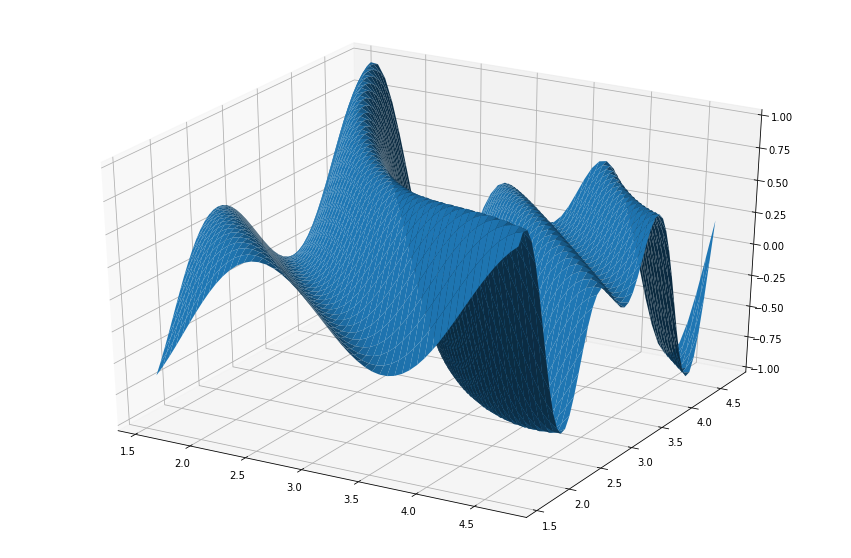

In [120]:
if show3d:
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111, projection='3d')

    
    surf = ax.plot_surface(X, Y, u_gold)
    ax.set_zlim(-1, 1)

    plt.show()

## 5.2 Approximation 3d

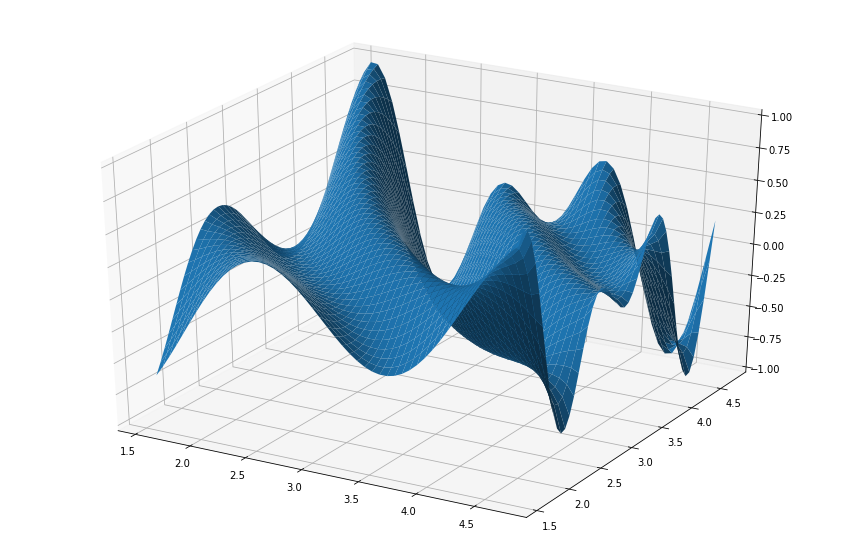

In [121]:
if show3d:
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111, projection='3d')

    surf = ax.plot_surface(X, Y, u_values)
    ax.set_zlim(-1, 1)

    plt.show()

## 6. Plot Errors
Here, I use simle errors - just the difference between values of the approximation and the golden model

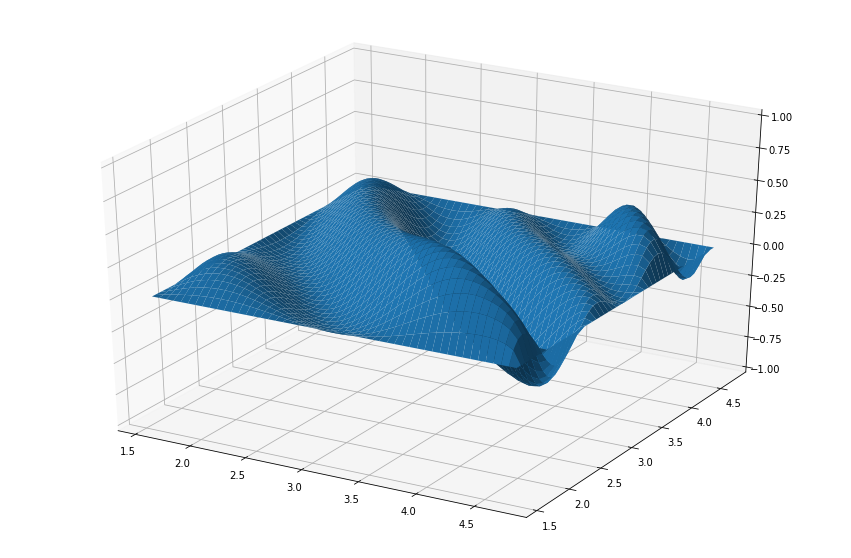

In [122]:
if show3d:
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111, projection='3d')

    u_gold = u_gold_func(X, Y)
    surf = ax.plot_surface(X, Y, u_gold - u_values)
    ax.set_zlim(-1, 1)

    plt.show()

## 7. For a clear view, let's plot projections for either dimension

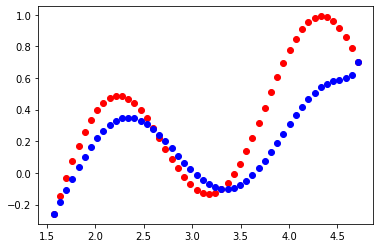

In [123]:
projection = 4

plt.plot(X[0], u_gold[projection], 'ro', X[0], u_values[projection], 'bo')
plt.show()

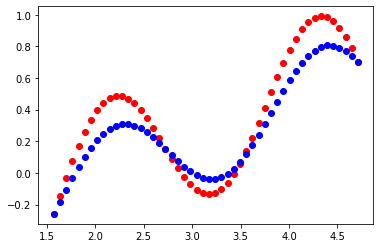

In [124]:
plt.plot(Y[:, 0], u_gold[:, projection], 'ro', Y[:, 0], u_values[:, projection], 'bo')
plt.show()